Refer to https://colab.research.google.com/drive/1gDZ2xcTOgR39tGGs-EZ6i3RTs16wmzZQ for original Colab notebook

In [1]:
# clone YOLOv5 repository

!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

/home/ec2-user/SageMaker/yolov5


In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires nvidia-ml-py3, which is not installed.
Setup complete. Using torch 1.10.1+cu102 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [3]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires nvidia-ml-py3, which is not installed.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.24.12 which is incompatible.


Matplotlib is building the font cache; this may take a moment.


upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=roboflow-yolov5


In [4]:
%cd /content/yolov5
#after following the link above, recieve python code with these fields filled in
from roboflow import Roboflow
rf = Roboflow(api_key="m7PCFCEsCIIWDlFBEI7i")
project = rf.workspace("ethh").project("yolov5-gszpw")
dataset = project.version(3).download("yolov5")

[Errno 2] No such file or directory: '/content/yolov5'
/home/ec2-user/SageMaker/yolov5
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to yolov5-3 in yolov5pytorch:: 100%|██████████| 24/24 [00:00<00:00, 1696.24it/s]


In [5]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- '0'
nc: 1
train: yolov5-3/train/images
val: yolov5-3/valid/images


In [6]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [11]:
#this is the model configuration we will use for our tutorial 
%cat models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [12]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [14]:
%%writetemplate models/custom_yolov5s.yaml

# parameters
nc: 1  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [3]:
# train yolov5s on custom data for 100 epochs
# time its performance
%time
# %cd yolov5/
!python train.py --img 1952 --batch 8 --epochs 200 --data yolov5-3/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 32 (delta 19), reused 32 (delta 19), pack-reused 0
Unpacking objects: 100% (32/32), done.
From https://github.com/ultralytics/yolov5
   bc8c651..8941467  test/conv_reduction -> origin/test/conv_reduction
github: ⚠️ WARNING: code is out of date by 925 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-126-g886f1c0 torch 1.10.1+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Namespace(adam=False, batch_size=8, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='yolov5-3/data.yaml', device='', entity=None, epochs=200, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[1952, 1952], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi

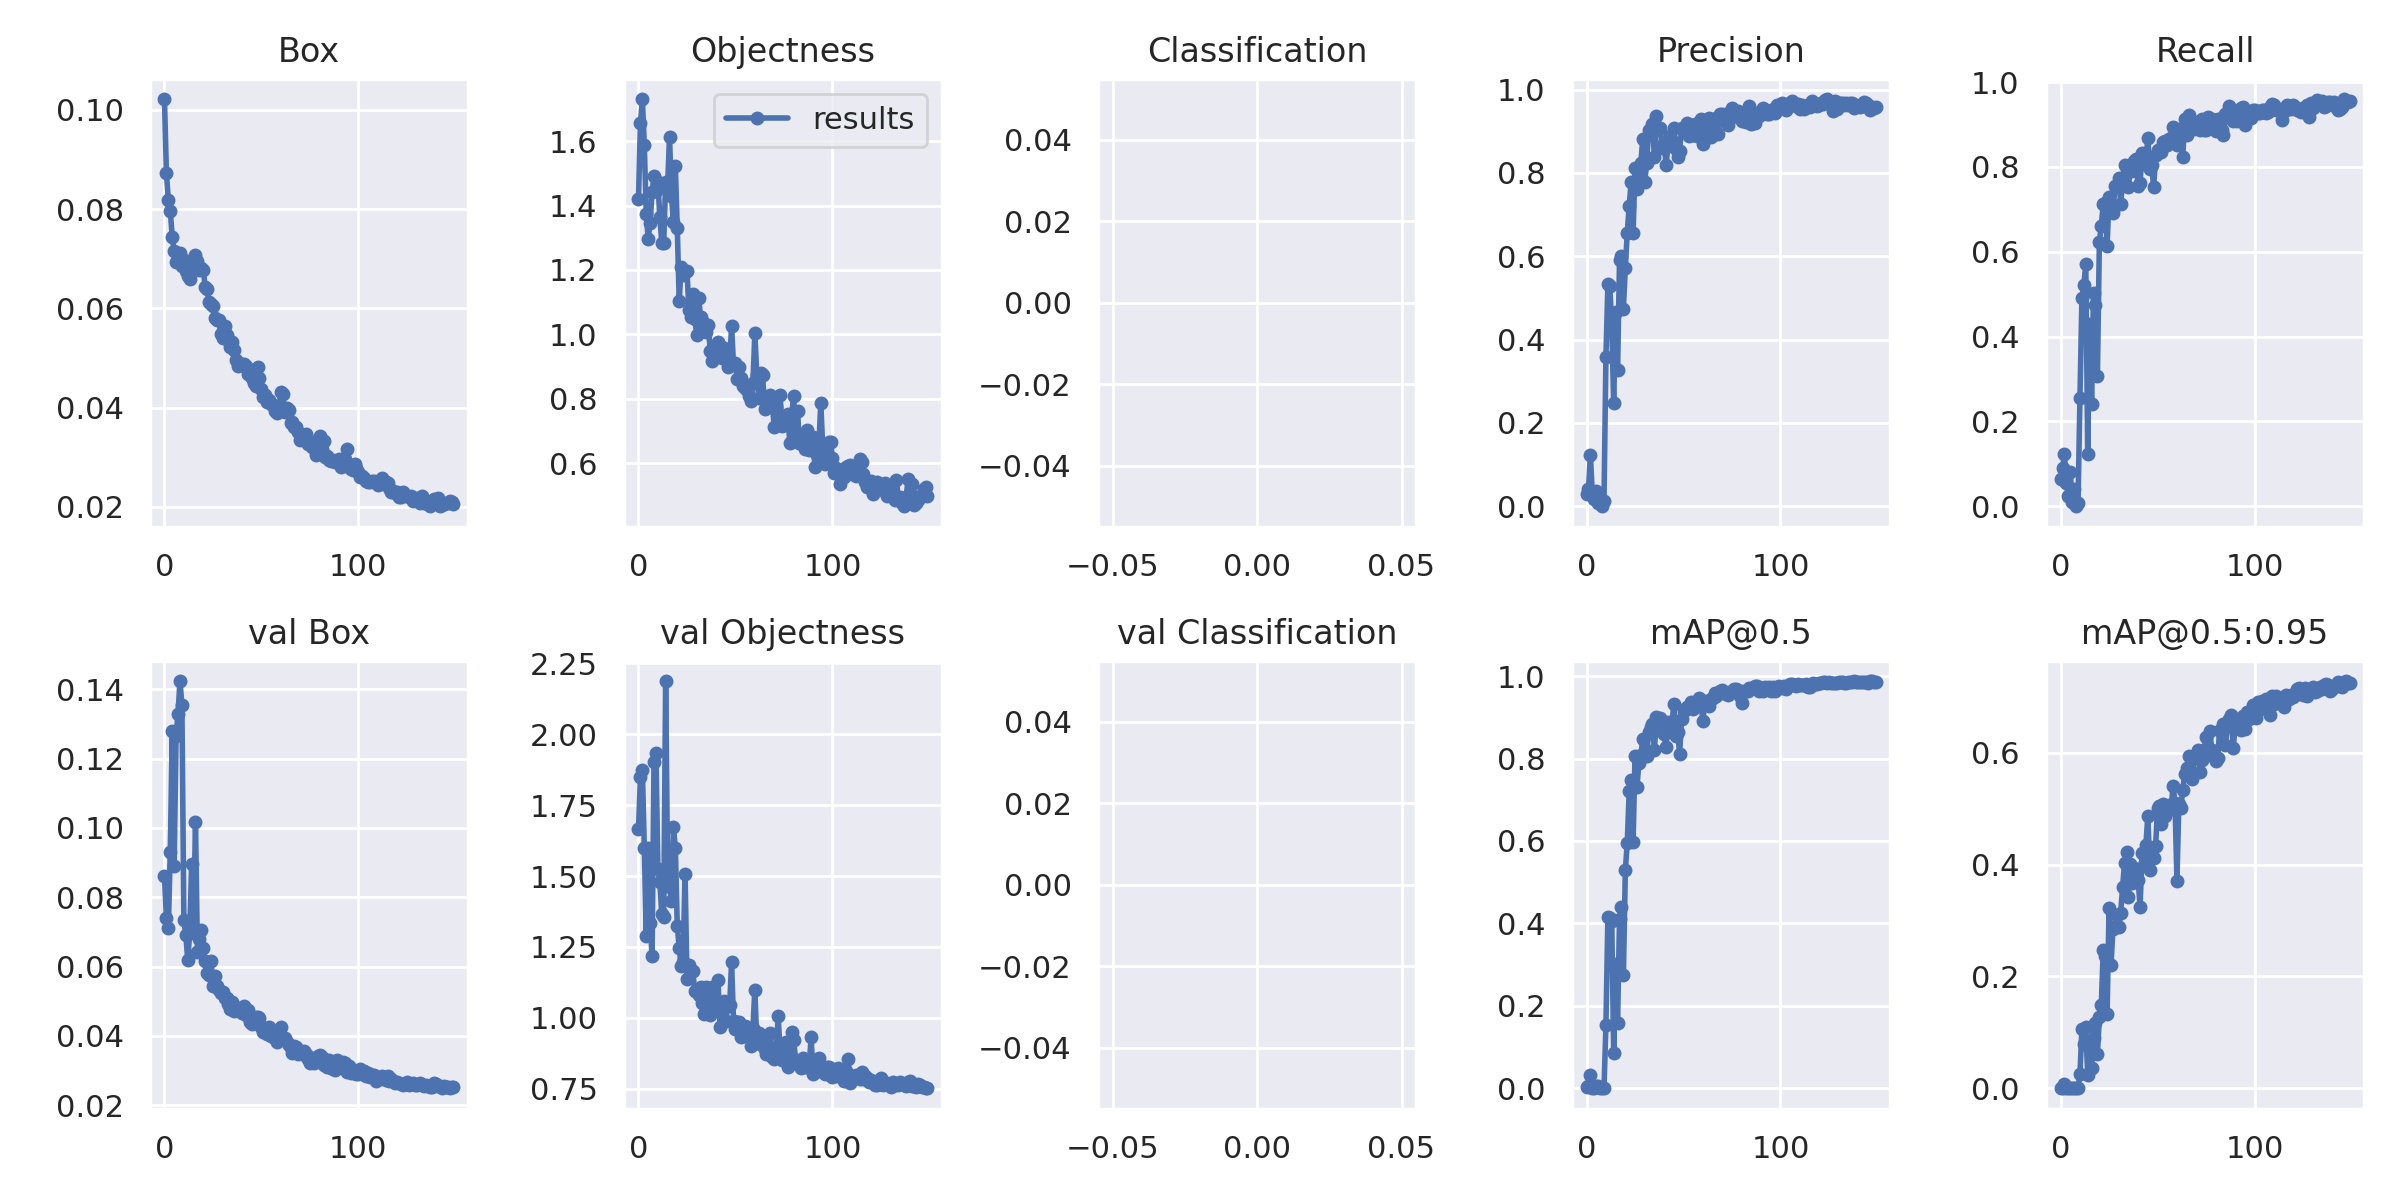

In [5]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='runs/train/yolov5m_results/results.png', width=1000)  # view results.png

GROUND TRUTH TRAINING DATA:


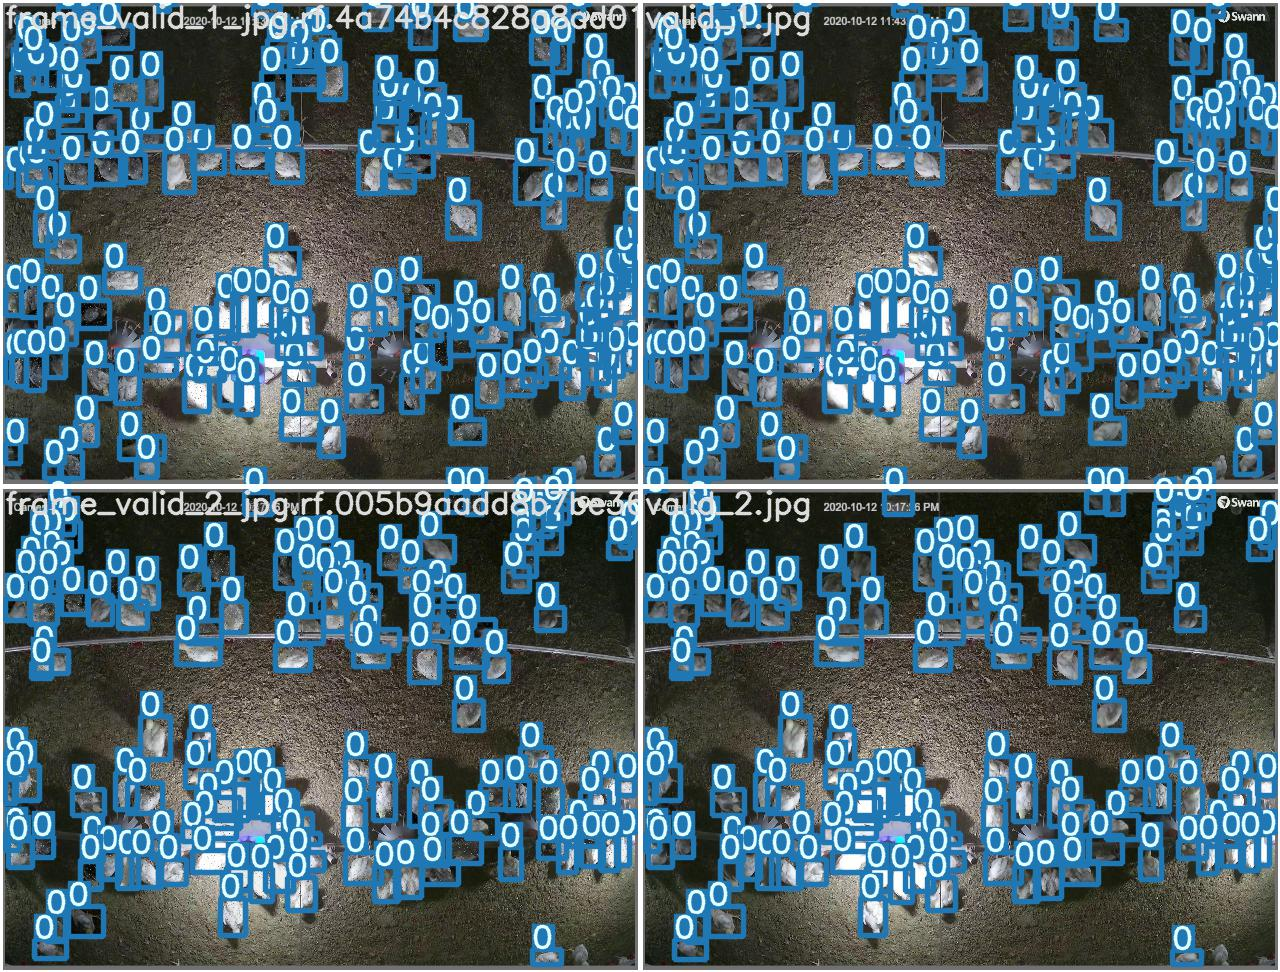

In [6]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='runs/train/yolov5m_results/test_batch0_labels.jpg', width=1000)

GROUND TRUTH AUGMENTED TRAINING DATA:


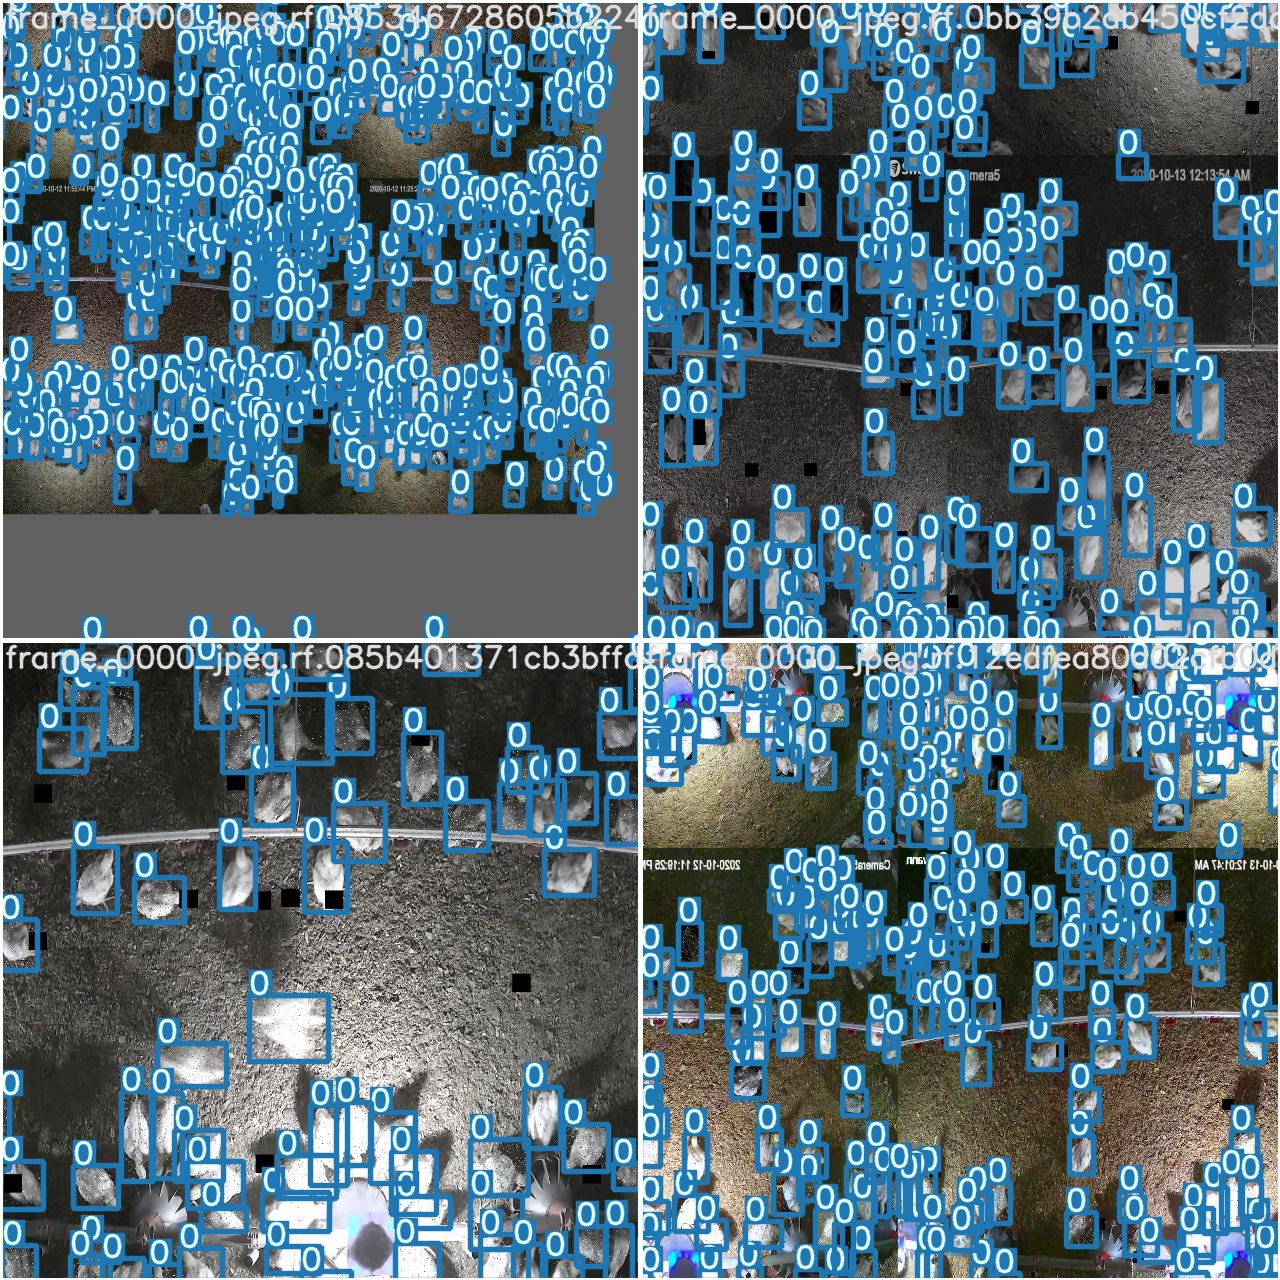

In [7]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='runs/train/yolov5m_results/train_batch0.jpg', width=1500)

In [3]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 1952 --conf 0.5 --source yolov5-3/test/images --save-txt

[Errno 2] No such file or directory: 'yolov5/'
/home/ec2-user/SageMaker/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=False, img_size=1952, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='yolov5-3/test/images', update=False, view_img=False, weights=['runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.10.1+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPS
image 1/1 /home/ec2-user/SageMaker/yolov5/yolov5-3/test/images/test.jpg: 1120x1952 216 0s, Done.

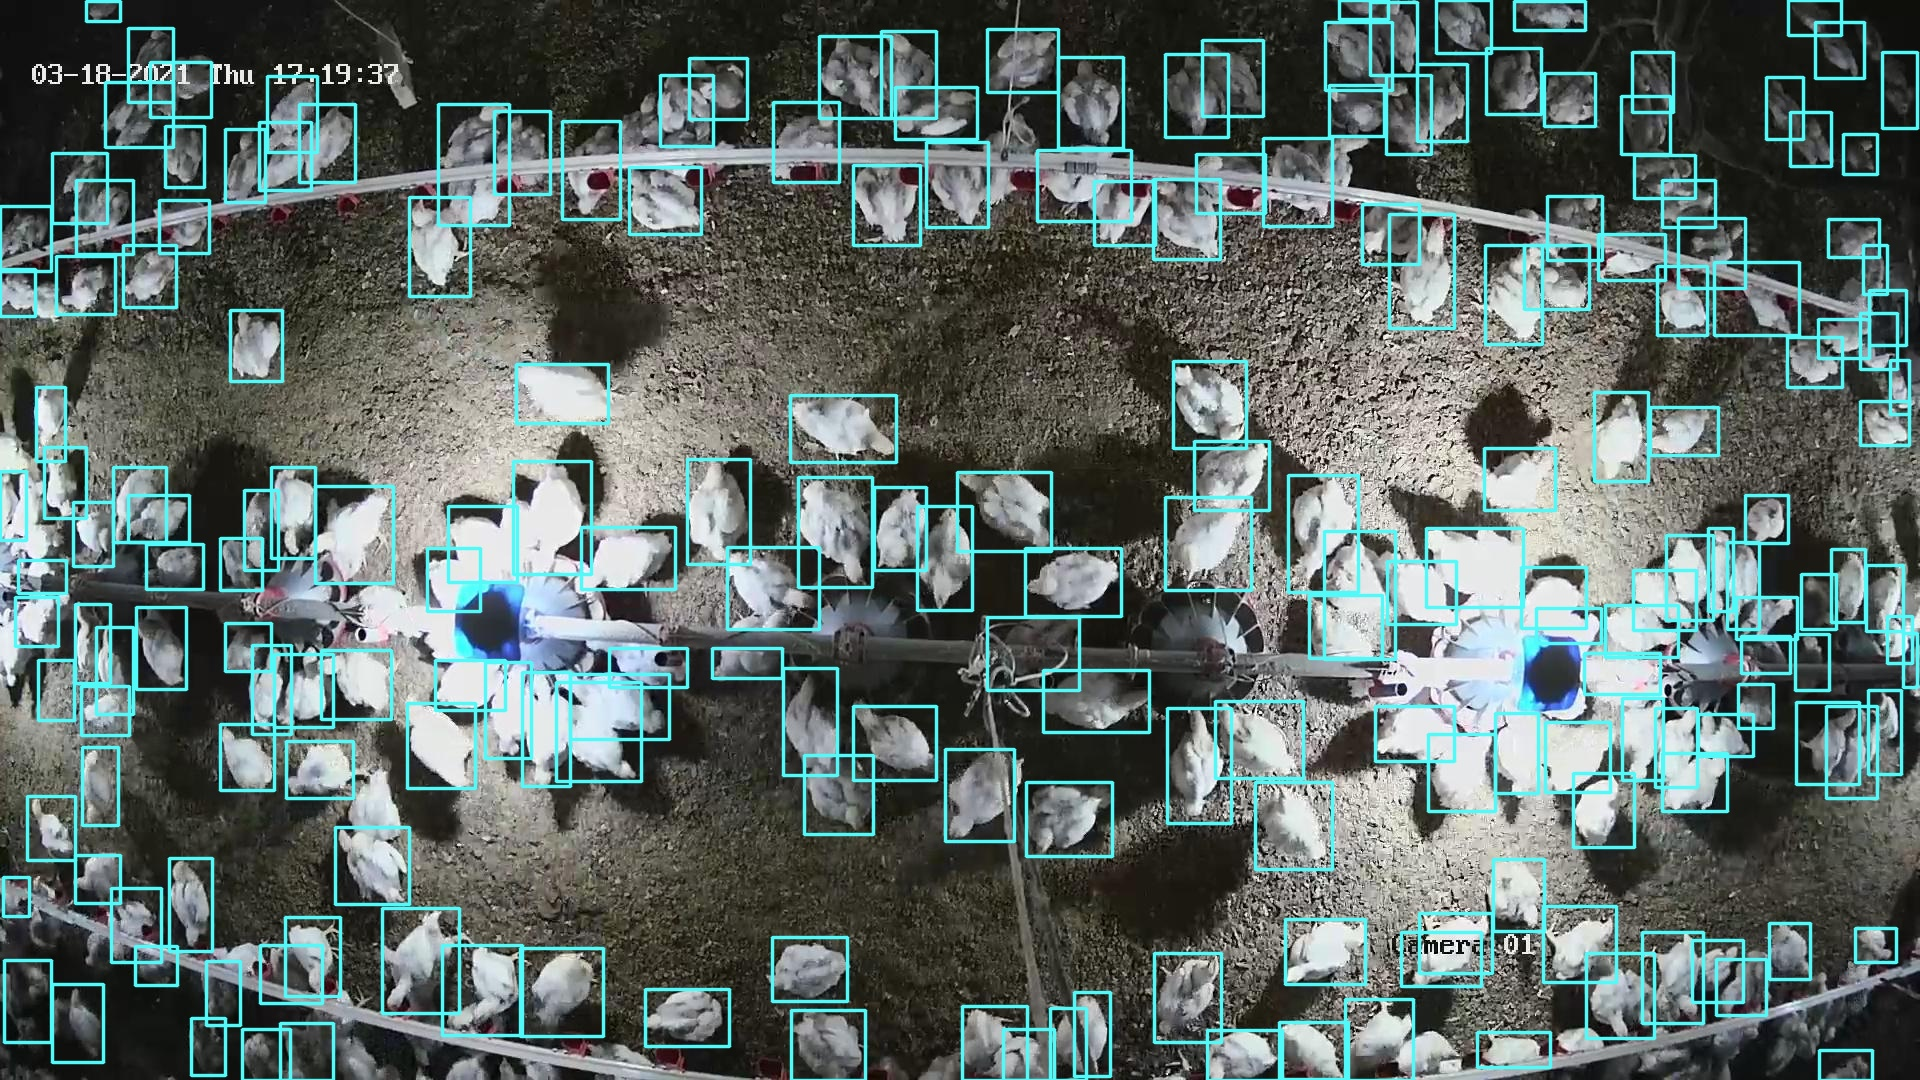

In [28]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [6]:
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 1952 --conf 0.5 --source videos/20201017_0700.avi --save-txt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=False, img_size=1952, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='videos/20201017_0700.avi', update=False, view_img=False, weights=['runs/train/yolov5s_results/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.10.1+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPS
video 1/1 (1/193) /home/ec2-user/SageMaker/yolov5/videos/20201017_0700.avi: 1472x1952 137 0s, Done. (0.039s)
video 1/1 (2/193) /home/ec2-user/SageMaker/yolov5/videos/20201